# Step 4: CPI Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from datetime import datetime
%matplotlib inline

### Load Inputs from previous programs

In [2]:
from statsmodels.regression.linear_model import OLSResults
result = OLSResults.load("cadre_model.pickle")
cpi = pd.read_csv("cadre_cpi.csv", index_col='period', parse_dates=True)
frm30yr = pd.read_csv('frm30yr_pred.csv', index_col='period', parse_dates=True)
frm30yr_chg = pd.read_csv('frm30yr_chg_pred.csv', index_col='period', parse_dates=True)
pop_gr = pd.read_csv('pop_gr_pred.csv', index_col='period', parse_dates=True)
mean_all = pd.read_csv('mean_all.csv')
dist_all = pd.read_csv('dist_all.csv')

### Convert data from Wide to Long

In [3]:
def w_to_l(df,id1,col1,col2):
    df.reset_index(inplace=True)
    df = pd.melt(df, id_vars=[id1],value_vars=df.columns[1:])
    df.columns = [id1,col1,col2]
    df[col1] = pd.to_numeric(df[col1])
    return df

### De-normalize variables for projection

In [4]:
frm30yr['mortgage30us'] = (frm30yr['mortgage30us'] - mean_all['mean_frm30yr'].iloc[0])/dist_all['dist_frm30yr'].iloc[0]
frm30yr_chg['mortgage30us'] = (frm30yr_chg['mortgage30us'] - mean_all['mean_frm30yr_chg'].iloc[0])/dist_all['dist_frm30yr_chg'].iloc[0]

pop_gr = w_to_l(pop_gr,'period','cbsa','pop_gr')

mean_pop = mean_all[['cbsa','mean_pop']]
dist_pop = dist_all[['cbsa','dist_pop']]

pop_gr = pop_gr.merge(mean_pop, how='left', left_on=['cbsa'], right_on=['cbsa'])
pop_gr = pop_gr.merge(dist_pop, how='left', left_on=['cbsa'], right_on=['cbsa'])

pop_gr['pop_gr'] = (pop_gr['pop_gr'] - pop_gr['mean_pop'])/pop_gr['dist_pop']

pop_gr = pop_gr[['period','cbsa','pop_gr']].pivot(index='period', columns='cbsa', values='pop_gr')

In [5]:
cities_cbsa = [12060, 14460, 16980, 19100, 26420, 31080, 33100, 35620, 37980, 47900]

In [6]:
idx_pred = pd.DatetimeIndex(start=datetime(2017,7,1), end=datetime(2019,7,1), freq="QS", name='period')
row_lst = list(product(idx_pred,cities_cbsa))

cpi.reset_index(inplace=True)
cpi.set_index(['period','cbsa'], inplace=True)
cpi = cpi.reindex(row_lst)
cpi.reset_index(level='cbsa',inplace=True)

In [7]:
cpr = cpi[['cbsa','ret']]

cpr.reset_index(inplace=True)

cpr.set_index(['period','cbsa'], inplace=True)

In [8]:
cpr = cpr.unstack()
cpr.columns = cities_cbsa
cpr_l1 = cpr.shift(1)

In [9]:
cpr_l1 = w_to_l(cpr_l1,'period','cbsa','return_l1')

In [10]:
cpr_l1.set_index(['period'], inplace=True)
cpr_l1 = cpr_l1['2017-10']
cpr_l1.reset_index(inplace=True)
cpr_l1.set_index(['period','cbsa'], inplace=True)

In [11]:
frm30yr['mortgage30us_l1'] = frm30yr.shift(1)
frm30yr_fill = frm30yr['2017-10':]
frm30yr_chg['mortgage30us_chg_l1'] = frm30yr_chg.shift(1)
frm30yr_chg_fill = frm30yr_chg['2017-10':]
pop_gr_l1 = pop_gr.shift(1)
pop_gr_fill = pop_gr['2017-10':]
pop_gr_l1_fill = pop_gr_l1['2017-10':]

In [12]:
pop_gr_l1_fill = w_to_l(pop_gr_l1_fill,'period','cbsa','pop_gr')

pop_gr_l1_fill.set_index(['period','cbsa'], inplace=True)

pop_gr_l1_fill.columns = ['pop_gr_l1']

In [13]:
cpi = cpi.fillna(frm30yr_fill)
cpi = cpi.fillna(frm30yr_chg_fill)

In [14]:
cpi.reset_index(inplace=True)

cpi.set_index(['period','cbsa'], inplace=True)

cpi = cpi.fillna(pop_gr_l1_fill)

cpi['intercept'] = 1

cpi = cpi.fillna(cpr_l1)

In [15]:
selected_vars = ['intercept','mortgage30us_l1','mortgage30us_chg_l1',
               'return_l1', 'pop_gr_l1']

In [16]:
mean_col = [col for col in cpi if col.startswith('mean')]
dist_col = [col for col in cpi if col.startswith('dist')]
cpi.drop(mean_col, axis=1, inplace=True)
cpi.drop(dist_col, axis=1, inplace=True)

cpi.reset_index(inplace=True)
cpi = cpi.merge(mean_all, how='left', left_on=['cbsa'], right_on=['cbsa'])
cpi = cpi.merge(dist_all, how='left', left_on=['cbsa'], right_on=['cbsa'])

cpi.set_index(['period','cbsa'], inplace=True)

### Run for loop to use return and price at time T-1 to calculate price at time T

In [17]:
for t in range(1,len(idx_pred)):

    X = cpi.loc[idx_pred[t].strftime("%Y-%m")][selected_vars]

    cpi['normreturn_pred'] = result.predict(X)

    cpi.reset_index(inplace=True)
    cpr_normpred = cpi.pivot(index='period', columns='cbsa', values='normreturn_pred')
    mean_cpr = cpi.pivot(index='period', columns='cbsa', values='mean_cpr')
    dist_cpr = cpi.pivot(index='period', columns='cbsa', values='dist_cpr')
    cpi_actual = cpi.pivot(index='period', columns='cbsa', values='cpi')

    cpr_pred = (cpr_normpred * dist_cpr) + mean_cpr
    cpi_pred = cpi_actual.shift(1) * (1 + cpr_pred)
    cpi.set_index(['period','cbsa'], inplace=True)

    cpi_pred = cpi_pred[idx_pred[t].strftime("%Y-%m")]
    cpi_pred = w_to_l(cpi_pred,'period','cbsa','cpi')
    cpi_pred.set_index(['period','cbsa'], inplace=True)

    cpr_pred = cpr_pred[idx_pred[t].strftime("%Y-%m")]
    cpr_pred = w_to_l(cpr_pred,'period','cbsa','ret')
    cpr_pred.set_index(['period','cbsa'], inplace=True)

    cpr_pred_l1 = cpr_pred.unstack()
    cpr_pred_l1.columns = cities_cbsa
    cpr_pred_l1.index = cpr_pred_l1.index.shift(1, freq='QS')
    cpr_pred_l1 = w_to_l(cpr_pred_l1,'period','cbsa','return_l1')
    cpr_pred_l1.set_index(['period','cbsa'], inplace=True)

    cpi = cpi.fillna(cpi_pred)
    cpi = cpi.fillna(cpr_pred)
    cpi = cpi.fillna(cpr_pred_l1)

# Projection

In [18]:
cpi.reset_index(inplace=True)
df = pd.DataFrame()
df = cpi.pivot(index='period', columns='cbsa', values='cpi')

### Price Projection

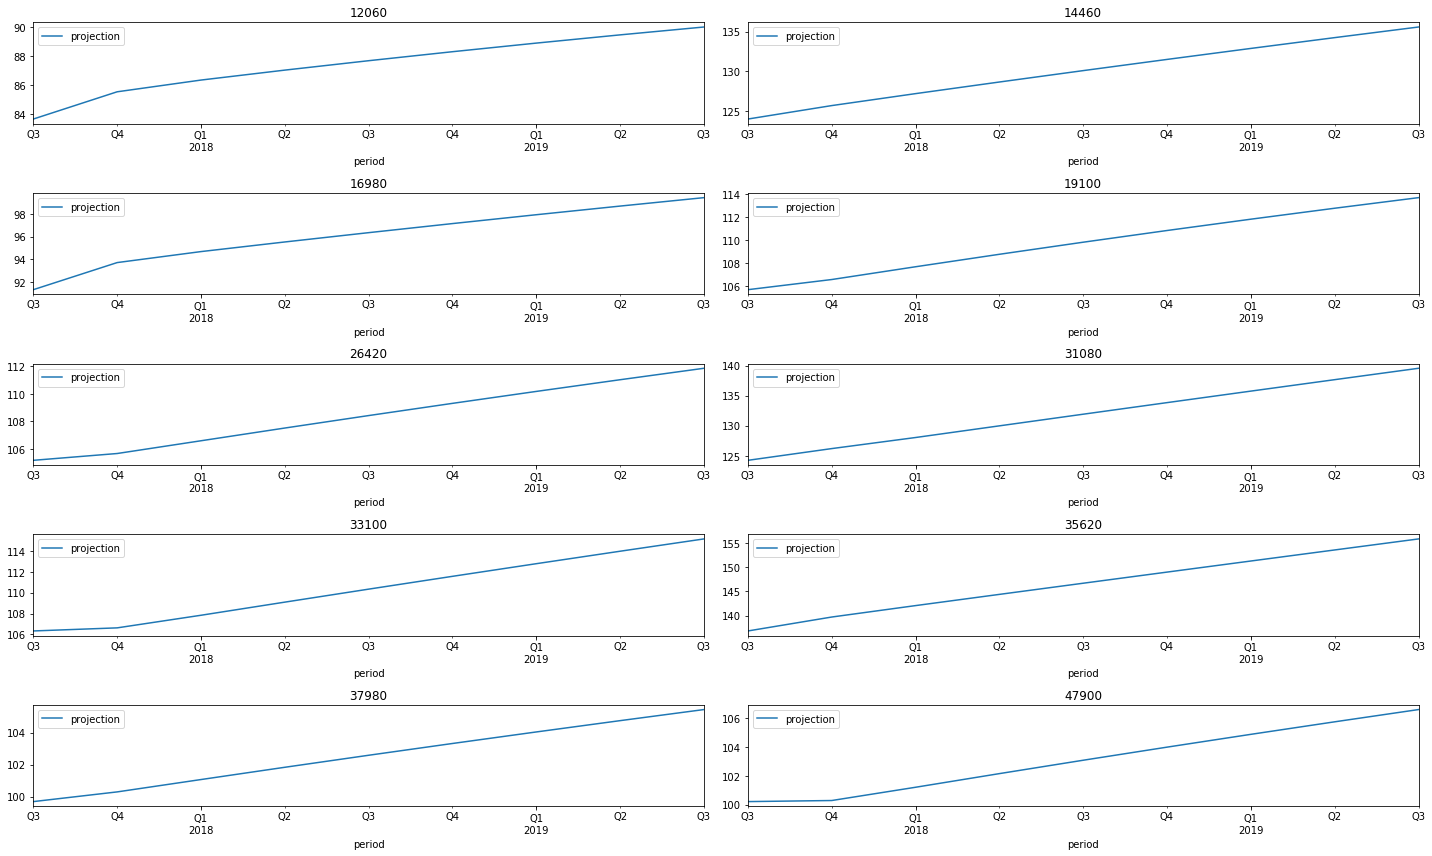

In [19]:
nrow=5
ncol=2

fig, axes = plt.subplots(nrow, ncol)
fig.set_size_inches(20, 12)

# plot counter
count=0
i=0
for r in range(nrow):
    for c in range(ncol):
        df.loc['2017-04':][cities_cbsa[i]].plot(ax=axes[r,c], title=cities_cbsa[i], label='projection', legend=True)
        count+=1
        i+=1
fig.tight_layout()

Prices in all areas are increasing at a stable rate. This is partly due to a simple approach used in the previous steps (VAR and AR1). This can be improved later.

### Return Projection

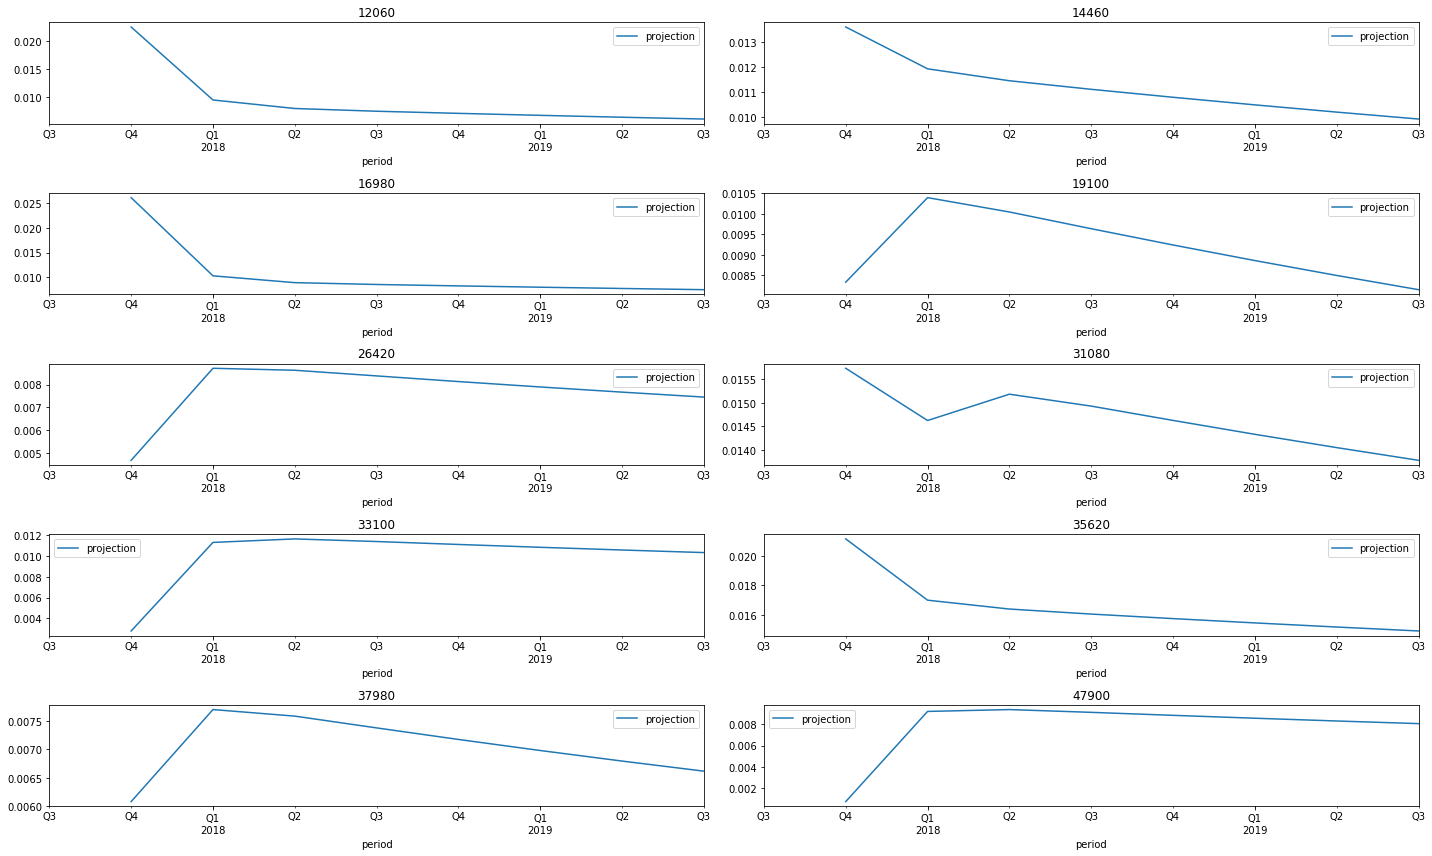

In [23]:
df_ret = df.pct_change()
nrow=5
ncol=2

fig, axes = plt.subplots(nrow, ncol)
fig.set_size_inches(20, 12)

# plot counter
count=0
i=0
for r in range(nrow):
    for c in range(ncol):
        df_ret.loc['2017-07':][cities_cbsa[i]].plot(ax=axes[r,c], title=cities_cbsa[i], label='projection', legend=True)
        count+=1
        i+=1
fig.tight_layout()

# Summary

Price projections in all areas looks reasonable. However, due to time constraint, this model has some drawbacks and thus can be improved as described below:
- Split data into training set and test set. This is a better practice to validate models.
- Try alternative modeling approach e.g. ARIMA to capture more factors.
- Low correlation by year needs further investigation.

# Export results to CSV

In [110]:
mkt_to_name = pd.read_csv('Q2_market_to_name.csv')

In [111]:
df.columns = df.columns.map(int)

mkt_nm = dict(zip(mkt_to_name.cbsa,mkt_to_name.name))

df = df.rename(columns=mkt_nm)

In [112]:
cpi_pred = df['2017-10':]

In [113]:
cpi_pred.to_csv('Q2_cpi_pred.csv')